In [5]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
# Define the ticker and download data
ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

price_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

print(price_data.head())
print(price_data.tail())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker             SPY         SPY         SPY         SPY        SPY
Date                                                                 
2020-06-19  288.229919  293.590329  286.259437  293.394224  135549600
2020-06-22  290.078918  290.480476  286.464843  287.622834   74649400
2020-06-23  291.414337  293.702332  291.003432  292.759113   68471200
2020-06-24  283.980743  289.976206  282.122350  289.350500  132813500
2020-06-25  287.025146  287.295977  281.356545  283.401724   89468000
Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2025-06-11  601.359985  605.059998  599.270020  604.190002  73658200
2025-06-12  603.750000  603.750000  599.520020  600.010010  64129000
2025-06-13  597.000000  601.849976  595.479980  598.500000  89506000
2025-06-16  602.679993  60

In [6]:
# Trading Signal

# Calculate the % returns
price_data['daily_return'] = price_data['Close'].pct_change()

# Calculate return from previous day by shift
price_data['signal'] = price_data['daily_return'].shift(1)

# Clean data
price_data.dropna(inplace=True)

# Print the head and tail
print("First 5 rows")
print(price_data[['Close', 'daily_return', 'signal']].head())

print("Last 5 rows")
print(price_data[['Close', 'daily_return', 'signal']].tail())

First 5 rows
Price            Close daily_return    signal
Ticker             SPY                       
Date                                         
2020-06-23  291.414337     0.004604  0.006415
2020-06-24  283.980743    -0.025509  0.004604
2020-06-25  287.025146     0.010720 -0.025509
2020-06-26  280.207886    -0.023751  0.010720
2020-06-29  284.326263     0.014698 -0.023751
Last 5 rows
Price            Close daily_return    signal
Ticker             SPY                       
Date                                         
2025-06-11  601.359985    -0.002852  0.005670
2025-06-12  603.750000     0.003974 -0.002852
2025-06-13  597.000000    -0.011180  0.003974
2025-06-16  602.679993     0.009514 -0.011180
2025-06-17  597.530029    -0.008545  0.009514


In [7]:
# BACKTEST WITH VECTOR AND STATISTICS
!pip install vectorbt
import vectorbt as vbt

long_threshold = 0.01
short_threshold = -0.01

#Entry
entries = price_data['signal'] > long_threshold
#Exit
exits = price_data['signal'] < short_threshold

portfolio = vbt.Portfolio.from_signals(
    close=price_data['Close'],
    open=price_data['Open'],
    entries = entries,
    exits = exits,
    init_cash = 100000,
    freq = 'D')

print(portfolio.stats())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.7 MB/s eta 0:00:00
Start                                2020-06-23 00:00:00
End                                  2025-06-17 00:00:00
Period                                1253 days 00:00:00
Start Value                                     100000.0
End Value                                  181477.663745
Total Return [%]                               81.477664
Benchmark Return [%]                          105.044829
Max Gross Exposure [%]                             100.0
Total Fees Paid                                      0.0
Max Drawdown [%]                               16.341537
Max Drawdown Duration                  503 days 00:00:00
Total Trades                                        96.0
Total Closed Trades                                 96.0
Total Open Trades    

<ipython-input-7-3684948630>:21: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x7c4975dd6340>. Pass column to select a single column/group.
  print(portfolio.stats())


Generating the complete backtest dashboard...


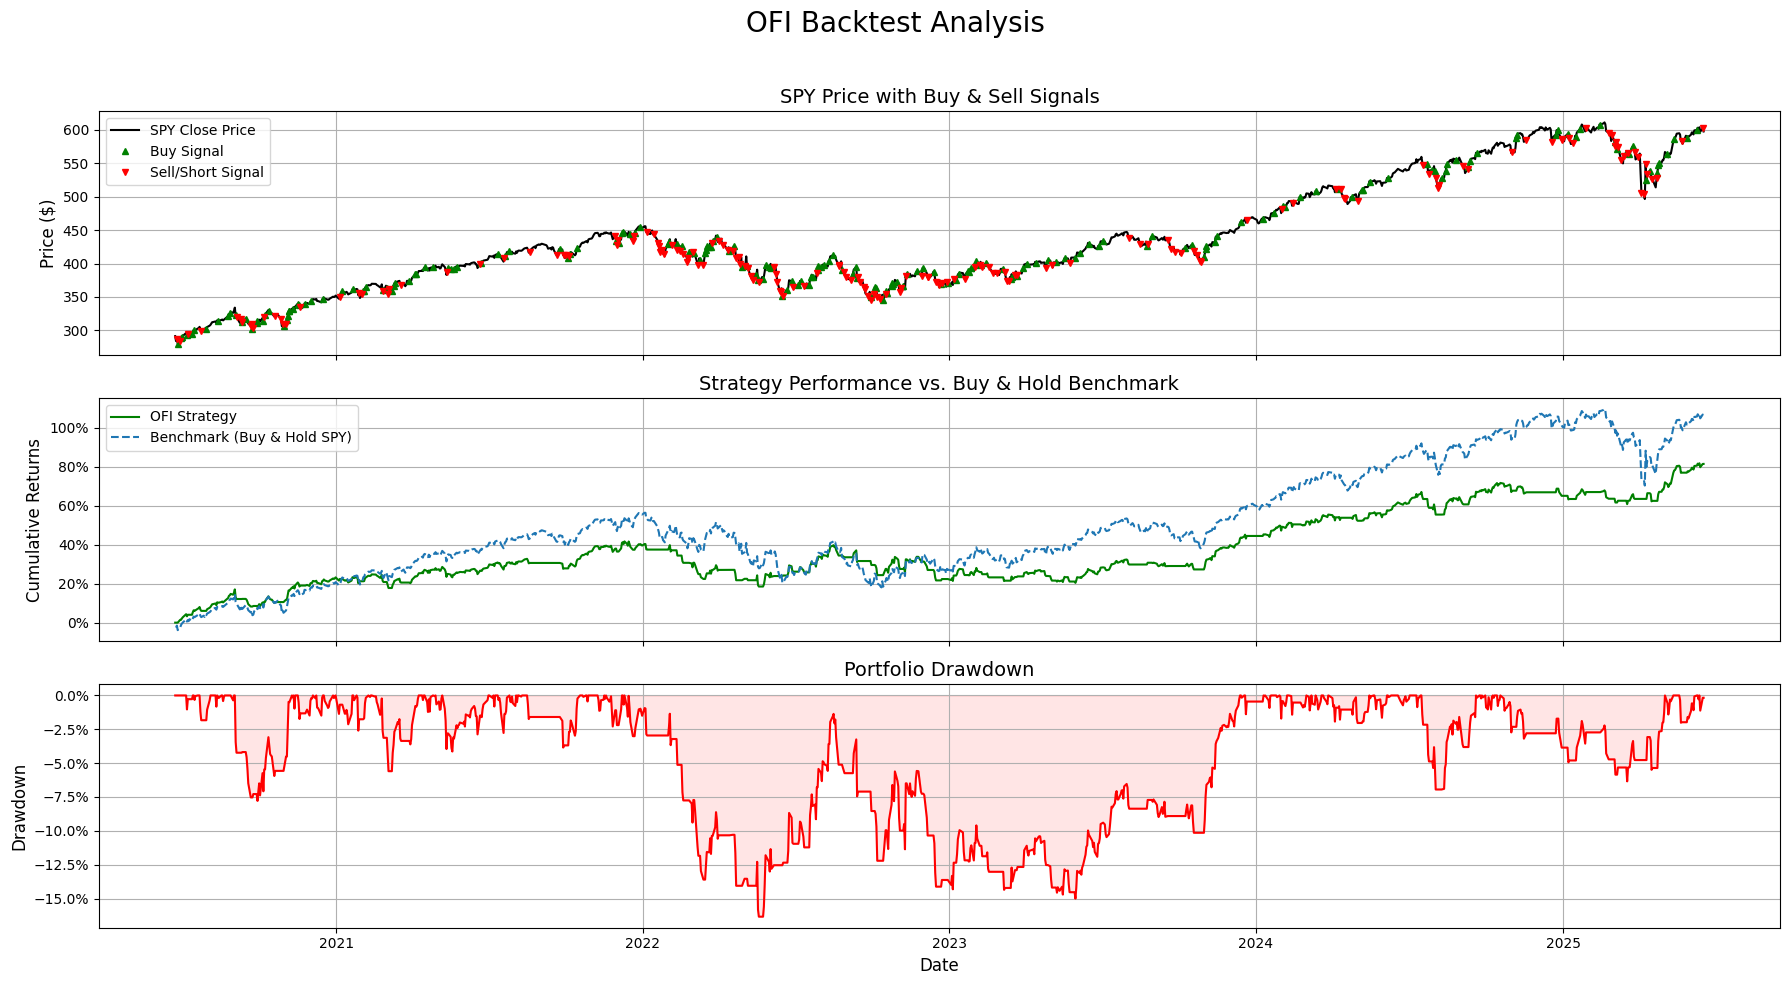

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Backtest Dashboard

print("Generating the complete backtest dashboard...")

# Data Preparation (Signals and Returns)
long_threshold = 0.01
short_threshold = -0.01
entries = price_data['signal'] > long_threshold
exits = price_data['signal'] < short_threshold

daily_returns = price_data['Close'].pct_change().dropna()
benchmark_cumulative_returns = (1 + daily_returns).cumprod() - 1
strategy_cumulative_returns = portfolio.cumulative_returns()
drawdown_series = portfolio.drawdown()['SPY']


#Three Subplots
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(18, 10),
    sharex=True)
fig.suptitle('OFI Backtest Analysis', fontsize=20)

#Price with Signals (Top Chart)
ax1.set_title('SPY Price with Buy & Sell Signals', fontsize=14)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.plot(price_data.index, price_data['Close'], label='SPY Close Price', color='k')
ax1.plot(price_data.loc[entries].index, price_data.loc[entries]['Close'], linestyle='None', marker='^', markersize=4, color='green', label='Buy Signal')
ax1.plot(price_data.loc[exits].index, price_data.loc[exits]['Close'], linestyle='None', marker='v', markersize=4, color='red', label='Sell/Short Signal')
ax1.grid(True)
ax1.legend()

#Cumulative Returns (Middle Chart)
ax2.set_title('Strategy Performance vs. Buy & Hold Benchmark', fontsize=14)
ax2.set_ylabel('Cumulative Returns', fontsize=12)
ax2.plot(strategy_cumulative_returns.index, strategy_cumulative_returns, label='OFI Strategy', color='green')
ax2.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Benchmark (Buy & Hold SPY)', linestyle= '--')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.grid(True)
ax2.legend()


#Drawdown Chart (Bottom Chart)
ax3.set_title('Portfolio Drawdown', fontsize=14)
ax3.set_ylabel('Drawdown', fontsize=12)
ax3.plot(drawdown_series.index, drawdown_series, color='red')
ax3.fill_between(drawdown_series.index, drawdown_series, 0, color='red', alpha=0.1)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax3.grid(True)



plt.xlabel('Date', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [18]:
# Calculate Compound Annual Growth Rate (CAGR)

strategy_cagr = portfolio.annualized_return()


# However, a better way to calculate the benchmark CAGR is from the price data directly.
# We can use vectorbt's vbt.Portfolio.from_price method to create a benchmark portfolio
# and then get its annualized return.

# Create a benchmark portfolio from the close prices
# Use from_holding to create a buy-and-hold benchmark portfolio
# Explicitly pass the frequency 'D'
benchmark_portfolio = vbt.Portfolio.from_holding(price_data['Close'], freq='D')

# Get the annualized return from the benchmark portfolio
# Call the method to get the actual value
benchmark_cagr = benchmark_portfolio.annualized_return()


print("CAGR Performance:")
# Access the scalar value from the Series before formatting
print(f"Strategy CAGR:         {strategy_cagr.iloc[0]:.2%}")
# Access the scalar value from the Series before formatting
print(f"Benchmark (B&H) CAGR:  {benchmark_cagr.iloc[0]:.2%}")
print("\n")


if strategy_cagr.iloc[0] > benchmark_cagr.iloc[0]:
    print("Conclusion: On an annualized basis, the strategy outperformed the benchmark.")
else:
    print("Conclusion: On an annualized basis, the strategy underperformed the benchmark.")

CAGR Performance:
Strategy CAGR:         18.96%
Benchmark (B&H) CAGR:  23.27%


Conclusion: On an annualized basis, the strategy underperformed the benchmark.
